In [1]:
import pandas as pd
import gzip
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

### Data Exploration and Clean up

In [2]:
metadata_columns = [
    'date',
    'network',
    'country',
    'station_id',
    'latitude',
    'longitude',
    'station_occurrence'
]

In [3]:
daily_columns = []
for day in range(1, 32):
    daily_columns.extend([
        f'precip_day_{day}',
        f'quality_flag_day_{day}',
        f'qc_code_day_{day}',
        f'obs_hour_day_{day}'
    ])

In [4]:
all_columns = metadata_columns + daily_columns

In [5]:
def read_pqcf_file(filename):
    with gzip.open(filename, 'rt') as f:
        df = pd.read_csv(f, delim_whitespace=True, names=all_columns)
    return df

In [6]:
df = read_pqcf_file('../data/raw/CR_199101.pqcf.gz')

In [7]:
df.head()

,date,network,country,station_id,latitude,longitude,station_occurrence,precip_day_1,quality_flag_day_1,qc_code_day_1,...,qc_code_day_29,obs_hour_day_29,precip_day_30,quality_flag_day_30,qc_code_day_30,obs_hour_day_30,precip_day_31,quality_flag_day_31,qc_code_day_31,obs_hour_day_31
0,1991/01,COSTA,RICA,98027,9.13333,-83.33334,0,10.0,0,U,...,U,13,0.0,0,U,13,0.0,0,U,13
1,1991/01,COSTA,RICA,98026,9.20000,-83.43332,0,30.0,0,U,...,U,13,0.0,0,U,13,0.0,0,U,13
2,1991/01,COSTA,RICA,98006,9.21667,-83.45000,0,19.9,0,U,...,U,13,0.0,0,U,13,0.0,0,U,13
3,1991/01,COSTA,RICA,96002,9.26667,-83.86667,0,0.1,0,U,...,U,13,0.0,0,U,13,0.0,0,U,13
4,1991/01,COSTA,RICA,96001,9.30000,-83.78334,0,0.0,0,U,...,U,13,0.0,0,U,13,0.0,0,U,13


In [8]:
def reshape_to_long(df):
    id_vars = ['date', 'network', 'country', 'station_id', 'latitude', 'longitude', 'station_occurrence']
    
    precip_data = []
    
    for day in range(1, 32):
        day_data = pd.DataFrame({
            'date': df['date'],
            'network': df['network'],
            'country': df['country'],
            'station_id': df['station_id'],
            'latitude': df['latitude'],
            'longitude': df['longitude'],
            'station_occurrence': df['station_occurrence'],
            'day': day,
            'precipitation': df.iloc[:, 7 + (day-1)*4],     
            'quality_flag': df.iloc[:, 8 + (day-1)*4],      
            'qc_code': df.iloc[:, 9 + (day-1)*4],           
            'obs_hour': df.iloc[:, 10 + (day-1)*4]        
        })
        precip_data.append(day_data)
    
    # Combine all days
    df_final = pd.concat(precip_data, ignore_index=True)
    
    # Convert numeric columns
    df_final['precipitation'] = pd.to_numeric(df_final['precipitation'], errors='coerce')
    df_final['latitude'] = pd.to_numeric(df_final['latitude'], errors='coerce')
    df_final['longitude'] = pd.to_numeric(df_final['longitude'], errors='coerce')
    df_final['obs_hour'] = pd.to_numeric(df_final['obs_hour'], errors='coerce')
    
    return df_final

In [9]:
df = reshape_to_long(df)

In [10]:
# Get all pqcf.gz files
files = glob.glob('../data/raw/CR_*.pqcf.gz')

# Create an empty list to store dataframes
dfs = []

# Read each file and append to the list
for file in files:
    try:
        df = read_pqcf_file(file)
        df['filename'] = file  # Optional: keep track of which file the data came from
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

In [11]:
# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

In [12]:
combined_df = reshape_to_long(combined_df)

In [13]:
combined_df.head()

,date,network,country,station_id,latitude,longitude,station_occurrence,day,precipitation,quality_flag,qc_code,obs_hour
0,1997/08,COSTA,RICA,10024,8.68333,-83.06668,0,1,0.0,0,U,13
1,1997/08,COSTA,RICA,96002,9.26667,-83.86667,0,1,0.0,0,U,13
2,1997/08,COSTA,RICA,96001,9.30000,-83.78334,0,1,6.8,0,U,13
3,1997/08,COSTA,RICA,92002,9.40000,-84.08334,0,1,51.4,0,U,13
4,1997/08,COSTA,RICA,90003,9.43333,-84.15000,0,1,31.3,0,U,13


In [14]:
combined_df[['year', 'month']] = combined_df['date'].str.split('/', expand=True)

In [15]:
combined_df['year'] = pd.to_numeric(combined_df['year'])
combined_df['month'] = pd.to_numeric(combined_df['month'])

In [16]:
column_order = [
    'date', 'year', 'month', 'day',
    'network', 'country', 'station_id', 
    'latitude', 'longitude', 'station_occurrence',
    'precipitation', 'quality_flag', 'qc_code', 'obs_hour'
]


In [17]:
combined_df = combined_df[column_order]

In [18]:
combined_df

,date,year,month,day,network,country,station_id,latitude,longitude,station_occurrence,precipitation,quality_flag,qc_code,obs_hour
0,1997/08,1997,8,1,COSTA,RICA,10024,8.68333,-83.06668,0,0.00,0,U,13
1,1997/08,1997,8,1,COSTA,RICA,96002,9.26667,-83.86667,0,0.00,0,U,13
2,1997/08,1997,8,1,COSTA,RICA,96001,9.30000,-83.78334,0,6.80,0,U,13
3,1997/08,1997,8,1,COSTA,RICA,92002,9.40000,-84.08334,0,51.40,0,U,13
4,1997/08,1997,8,1,COSTA,RICA,90003,9.43333,-84.15000,0,31.30,0,U,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68629,1994/09,1994,9,31,COSTA,RICA,76002,10.46667,-84.96667,0,-999.99,7,M,13
68630,1994/09,1994,9,31,COSTA,RICA,74008,10.48333,-85.41666,0,-999.99,7,M,13
68631,1994/09,1994,9,31,COSTA,RICA,74020,10.60000,-85.53333,0,-999.99,7,M,13
68632,1994/09,1994,9,31,COSTA,RICA,74021,10.65000,-85.53333,0,-999.99,7,M,13


In [19]:
#in the readme states that all months report 31 days, 
#but those that have not naturally 31 days are flagged as M in qc code and -9999.99.
#filter them out. 
combined_df = combined_df[combined_df['precipitation'] > 0]

In [20]:
combined_df['date'] = pd.to_datetime(combined_df.apply(
    lambda x: f"{x['year']}-{x['month']}-{x['day']}", 
    axis=1
))

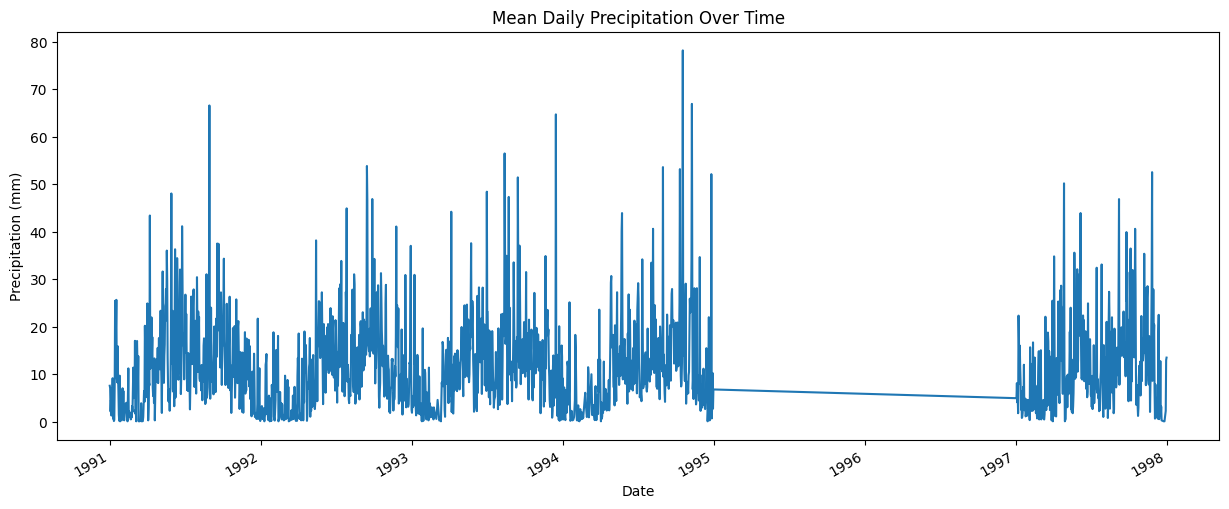

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
combined_df.groupby('date')['precipitation'].mean().plot(
    ax=ax,
    title='Mean Daily Precipitation Over Time',
    ylabel='Precipitation (mm)',
    xlabel='Date'
)
plt.show()
plt.savefig('../visuals/precipitation_daily_time.png')

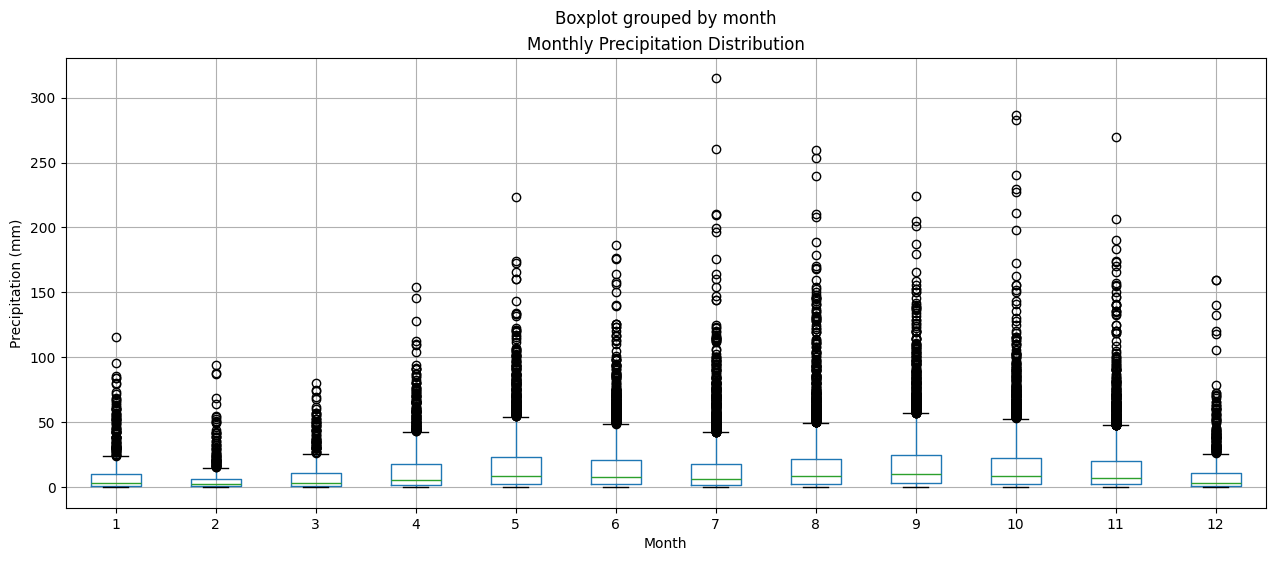

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
combined_df.boxplot(
    column='precipitation',
    by='month',
    ax=ax,
)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Month')
ax.set_title('Monthly Precipitation Distribution')
plt.show()


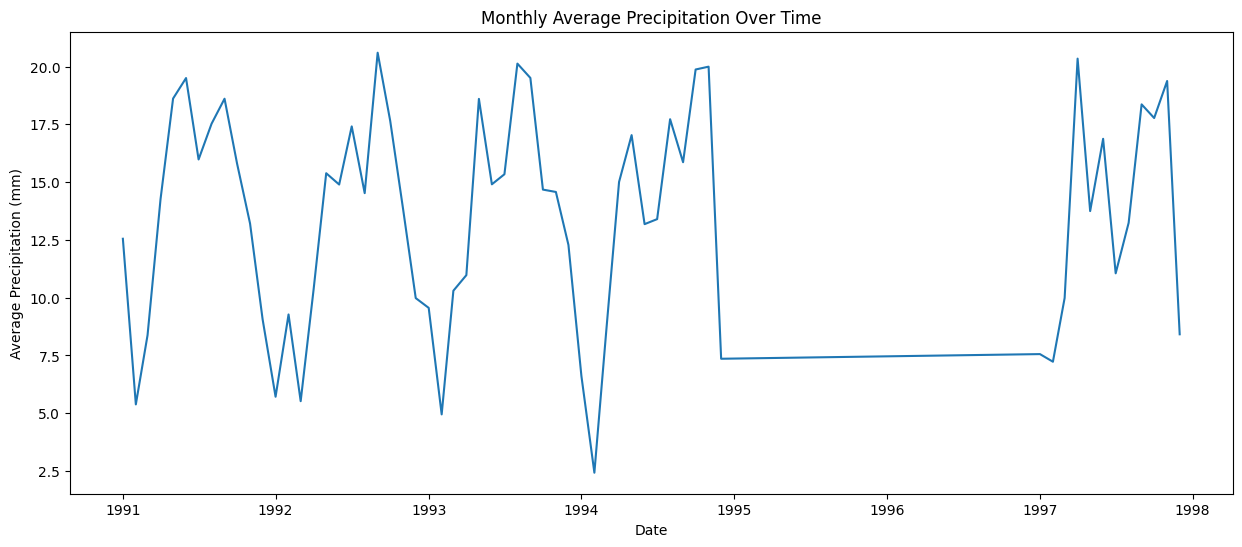

<Figure size 640x480 with 0 Axes>

In [23]:
# 3. Seasonal pattern using monthly averages
monthly_avg = combined_df.groupby(['year', 'month'])['precipitation'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    data=monthly_avg,
    x='date',
    y='precipitation',
    ax=ax
)
ax.set_title('Monthly Average Precipitation Over Time')
ax.set_ylabel('Average Precipitation (mm)')
ax.set_xlabel('Date')
plt.show()
plt.savefig('../visuals/precipitation_monthly_line.png')

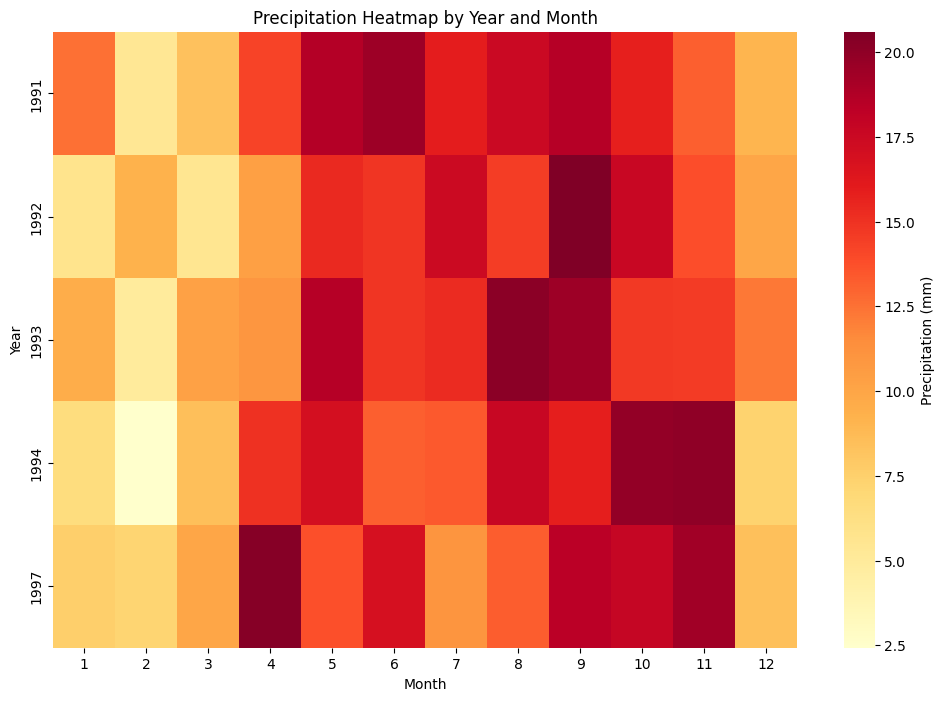

<Figure size 640x480 with 0 Axes>

In [24]:
pivot_data = combined_df.pivot_table(
    values='precipitation',
    index='year',
    columns='month',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    pivot_data,
    cmap='YlOrRd',
    ax=ax,
    cbar_kws={'label': 'Precipitation (mm)'}
)
ax.set_title('Precipitation Heatmap by Year and Month')
ax.set_xlabel('Month')
ax.set_ylabel('Year')
plt.show()
plt.savefig('../visuals/precipitation_year_heatmap.png')

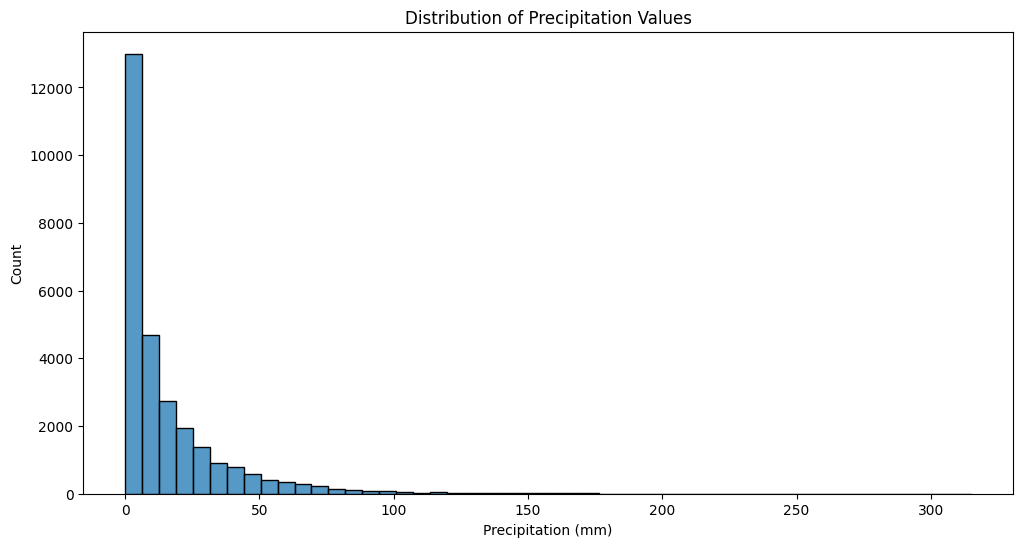

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    data=combined_df,
    x='precipitation',
    bins=50,
    ax=ax
)
ax.set_title('Distribution of Precipitation Values')
ax.set_xlabel('Precipitation (mm)')
ax.set_ylabel('Count')
plt.show()


### Questions
- "Has the rainfall pattern changed significantly over the years?"
- "Which regions of Costa Rica receive the most/least rainfall?"
- "Is there evidence of climate change in the precipitation patterns?"
- "How reliable is the rainfall during growing seasons?"
- "Are extreme rainfall events becoming more frequent?"
- "What is the spatial distribution of rainfall across Costa Rica?"
- "How do El Niño/La Niña events affect rainfall patterns?"
- "What is the typical duration of dry/wet spells?"

### Costa Rica Maps

In [26]:
m = folium.Map(location=[9.7489, -83.7534], zoom_start=8)  # Costa Rica's approximate center

# Add markers for each station (using unique station locations)
station_locations = combined_df[['station_id', 'latitude', 'longitude']].drop_duplicates()

In [27]:
station_precip = combined_df.groupby('station_id')['precipitation'].mean()

In [28]:
for idx, row in station_locations.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):  
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=10,
            popup=f"Station: {row['station_id']}\nMean Precipitation: {station_precip[row['station_id']]:.2f} mm",
            color='blue',
            fill=True
        ).add_to(m)

In [29]:
m.save('../visuals/costa_rica_stations.html')

### Precipitation and Coffee

In [30]:
harvest_months = [10, 11, 12, 1, 2]


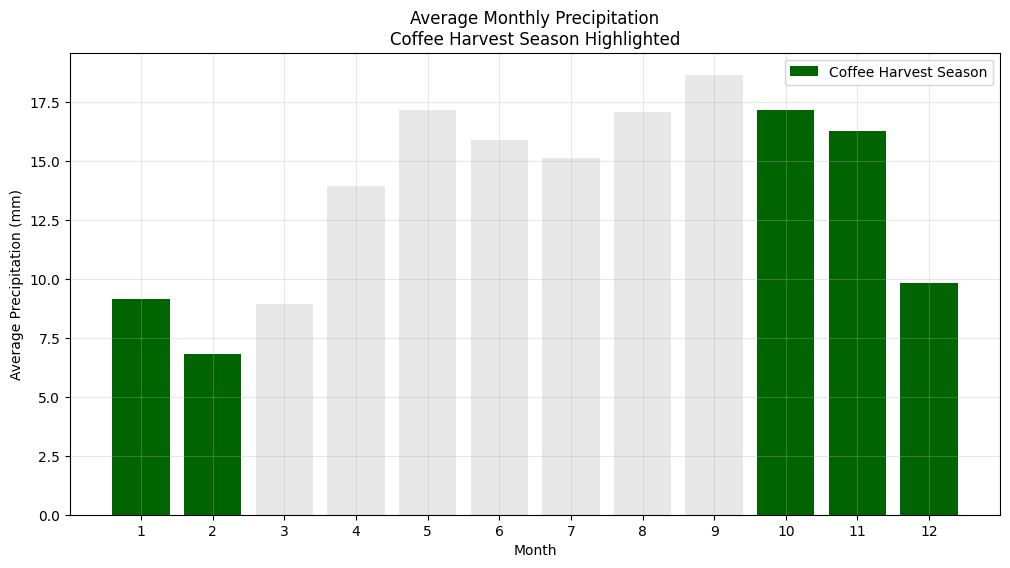

In [31]:
monthly_mean = combined_df.groupby('month')['precipitation'].mean()

plt.figure(figsize=(12, 6))
# Plot all months
plt.bar(monthly_mean.index, monthly_mean.values, color='lightgray', alpha=0.5)
# Highlight harvest months
harvest_data = monthly_mean[monthly_mean.index.isin(harvest_months)]
plt.bar(harvest_data.index, harvest_data.values, color='darkgreen', label='Coffee Harvest Season')

plt.title('Average Monthly Precipitation\nCoffee Harvest Season Highlighted')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.legend()
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.show()


<Figure size 1500x600 with 0 Axes>

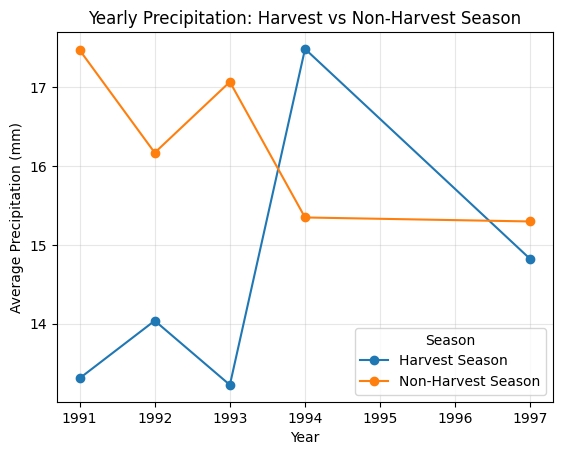

In [32]:
def classify_season(month):
    return 'Harvest Season' if month in harvest_months else 'Non-Harvest Season'

combined_df['season'] = combined_df['month'].apply(classify_season)

yearly_seasonal = combined_df.groupby(['year', 'season'])['precipitation'].mean().unstack()

plt.figure(figsize=(15, 6))
yearly_seasonal.plot(marker='o')
plt.title('Yearly Precipitation: Harvest vs Non-Harvest Season')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True, alpha=0.3)
plt.legend(title='Season')
plt.show()

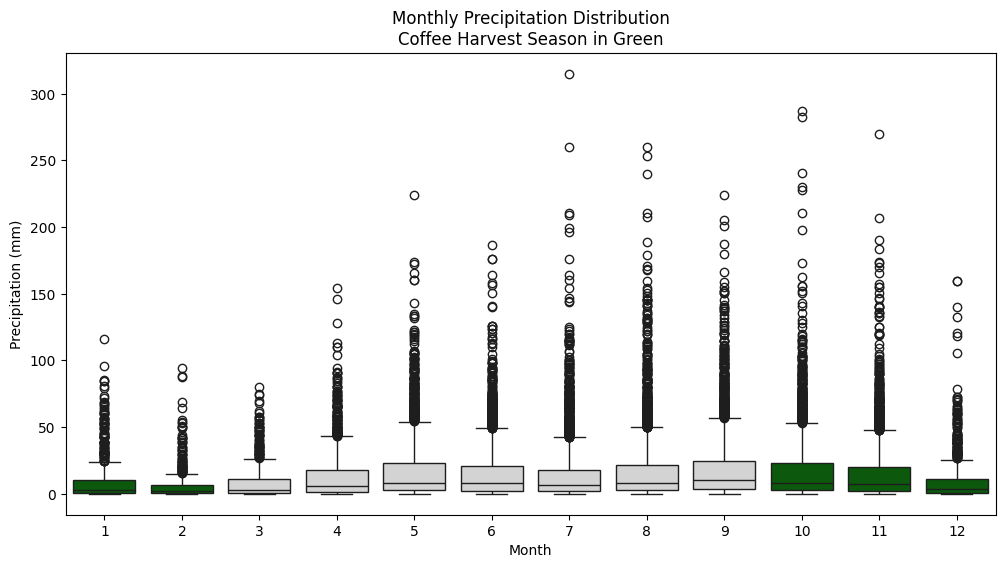

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='month', y='precipitation', 
            palette=['darkgreen' if x in harvest_months else 'lightgray' for x in range(1,13)])
plt.title('Monthly Precipitation Distribution\nCoffee Harvest Season in Green')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.show()

In [36]:
combined_df.set_index('date',inplace=True)

In [37]:
combined_df.to_csv('../data/unified_percipitation_data.csv')